In [42]:
%run init_notebook.py

In [43]:
import pandas as pd
import numpy as np

import os
import datetime as dt
from functools import wraps

import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
from settings import RAW_DATA_DIR, WORK_DATA_DIR, OUT_DATA_DIR, OUT_MODEL_DIR, random_state
from utils.utils import *
from utils.load import load_data, save_file, save_model
from utils.cast_data import apply_datetime_format
from utils.plotting import *
from src.src import *

In [4]:
# load data
df_all = load_data(file_name="merged_data.csv", file_path=WORK_DATA_DIR)
df_all.sort_values("date", inplace=True)
data_dict = load_data(file_name="data_dict.pkl", file_path=WORK_DATA_DIR)

('nan format unknonw',)
Unknown columns found
['date']


In [5]:
# select relevant data
drop_cols = data_dict["data_cols"]["fears"] + data_dict["data_cols"]["goog_sent"]
df_w = df_all.drop(drop_cols, axis=1).copy()

# get data on weekly basis
df_w = cut_to_weekly_data(df_w).reset_index(drop=True)

# get lead variable as target
# get lag variable as X
df_w = shift_var_relative_to_df(df_w, shift_var=["sp_close"], 
                                new_var_name=["sp_close_lead1"], no_lags=[-1])

df_w = shift_var_relative_to_df(df_w, shift_var=["sp_close", "sp_close", "sp_close"],
                                new_var_name=["sp_close_lag1", "sp_close_lag2", "sp_close_lag3"], no_lags=[1, 2, 3])

Applying shifts in future


In [6]:
df_w["sp_agg1"] = df_w.sp_close_lag1 + df_w.sp_close_lag2 + df_w.sp_close_lag3
df_w["sp_true_vals"] = df_w["sp_close"]

In [7]:
# edit data_dict
data_dict.update(predicted="sp_close_lead1")
data_dict.update(sp_true_vals="sp_true_vals")
data_dict.update(sp_cols=["sp_close", "sp_close_lead1", "sp_close_lag1", "sp_close_lag2", "sp_close_lag3", "sp_agg1"])


relevant_cols=[
    # 'fears35',
    'vixo',
    'naaim_ind',
    'ff_M_RF',
    'ff_SMB',
    'ff_HML',
    'ff_RMW',
    'ff_CMA',
    # 'ff_RF',
    'termspread',
    'pc_ratio',
    'aaii_Bullish',
    # 'goog_sent'
] 
relevant_cols = relevant_cols + data_dict["sp_cols"]

data_dict.update(relevant_cols=relevant_cols)
data_dict.update(predictor=[item for item in data_dict["relevant_cols"] if item != data_dict["predicted"]])

In [8]:
# log returns
# all cols but ff_factors, as these are returns already
df_w, dist, log = df_log_return(df_w,
                                cols=[item for item in data_dict["relevant_cols"] if item not in data_dict["data_cols"]["ff_factors5"]])

data_dict = update_dict(data_dict,
            update_keys=["dist_translation", "log_return"],
            update_vals=[dist, log])

In [9]:
# test normality & stationarity
stest = StatsTest(plot=False)

stationarity = stest.df_test_stationarity(df_w, data_dict["relevant_cols"])
data_dict.update(stationarity=stationarity)

normality = stest.df_test_normality(df_w, cols=data_dict["relevant_cols"])
data_dict.update(normality=normality)

stationarity

{'vixo': True,
 'naaim_ind': True,
 'ff_M_RF': True,
 'ff_SMB': True,
 'ff_HML': True,
 'ff_RMW': True,
 'ff_CMA': True,
 'termspread': True,
 'pc_ratio': True,
 'aaii_Bullish': True,
 'sp_close': True,
 'sp_close_lead1': True,
 'sp_close_lag1': True,
 'sp_close_lag2': True,
 'sp_close_lag3': True,
 'sp_agg1': True}

# correlation

In [37]:
# select model features
# predicted lead1
# why ar3 model
cols = [
    'vixo',
     'naaim_ind',
     'ff_M_RF',
     'ff_SMB',
     'ff_RMW',
     'ff_CMA',
    'ff_HML',
     'termspread',
     'pc_ratio',
     'aaii_Bullish',
    'sp_close',
    'sp_close_lag1',
    'sp_close_lag2',
    'sp_close_lag3',
    'sp_agg1',
    # 'goog_sent',
    # 'fears35'
]

In [38]:
df_ws = df_w[cols + [data_dict["predicted"]]].copy()

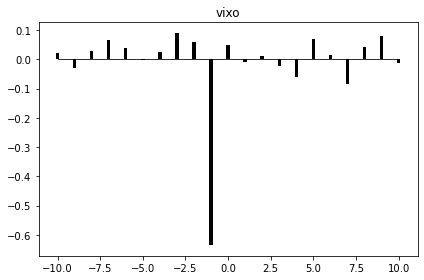

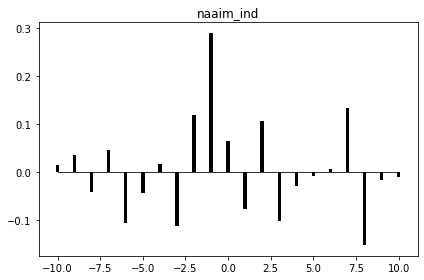

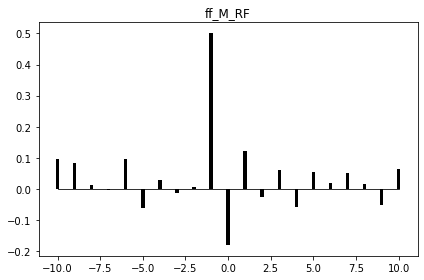

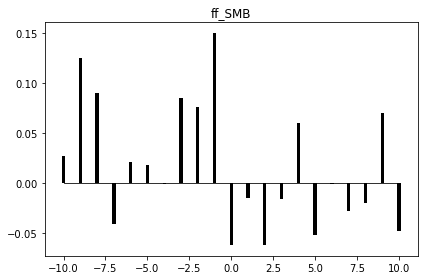

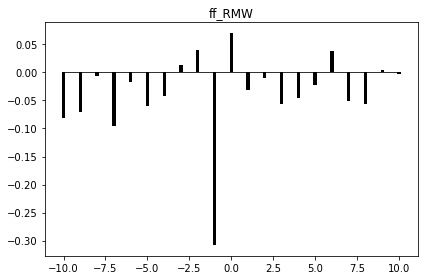

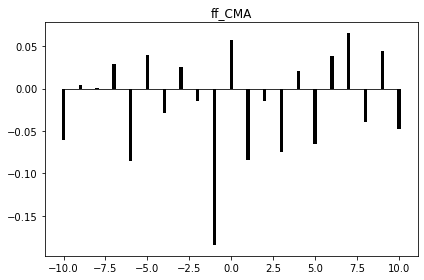

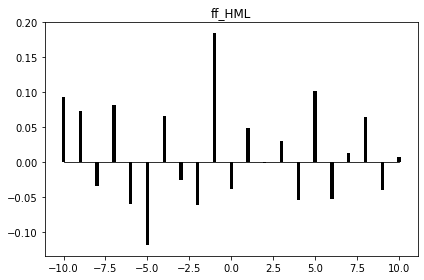

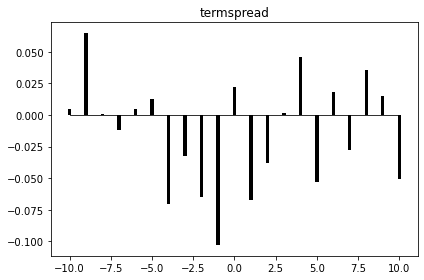

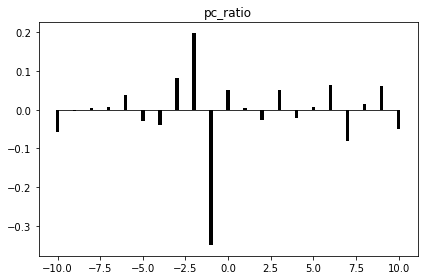

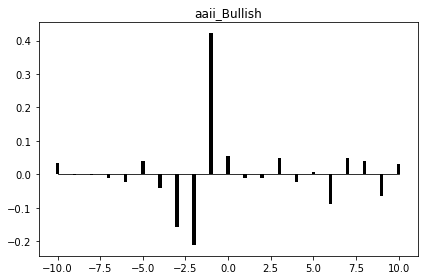

[['vixo', 7, 0.083],
 ['naaim_ind', 8, 0.152],
 ['ff_M_RF', 0, 0.181],
 ['ff_SMB', 9, 0.07],
 ['ff_RMW', 0, 0.07],
 ['ff_CMA', 1, 0.084],
 ['ff_HML', 5, 0.102],
 ['termspread', 1, 0.067],
 ['pc_ratio', 7, 0.081],
 ['aaii_Bullish', 6, 0.088]]

In [39]:
df_cross_corr(df_ws,
              [item for item in cols if item not in data_dict["sp_cols"]],
              "sp_close_lead1",
              show_plot=True)

In [40]:
df_ws = shift_var_relative_to_df(df_ws, shift_var=["ff_CMA", 
                                                   "vixo",
                                                   "naaim_ind",
                                                   "ff_HML"
                                                   # "naaim_ind",
                                                   # "aaii_Bullish"
                                                  ], no_lags=[
    1,
    7,
    8,
    5
    # 8,
    # 6
])

# Multicolinerarity

,VIF,corr_sp_close_lead1
ff_M_RF,1.704354,-0.181007
naaim_ind,1.029020,-0.152064
sp_close,1.682706,-0.147250
ff_CMA,1.054525,-0.083447
vixo,1.022172,-0.082649
ff_SMB,1.146064,-0.061698
sp_close_lag2,1130.398492,-0.009893
sp_agg1,2762.049966,0.011731
sp_close_lag1,1117.323003,0.013571
sp_close_lag3,1134.274108,0.018580


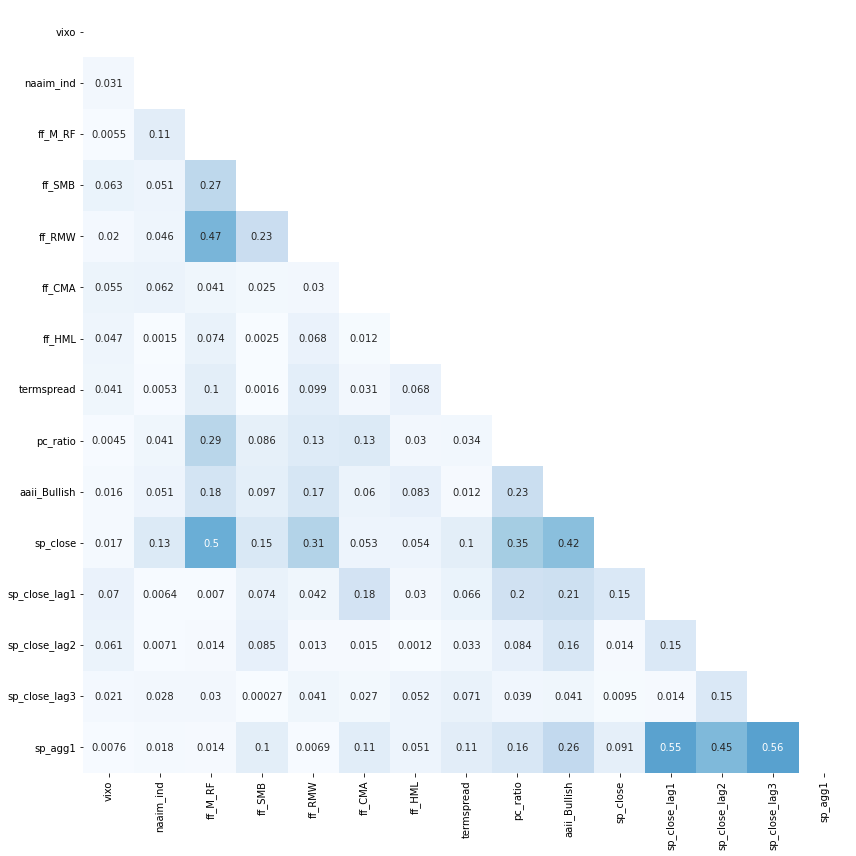

In [41]:
# only rely on correlation not vif
corr_heatmap(df_ws, 
             cols,
             size_factor=.8,
             show_fig=True)
get_variance_inflation_factor(df_ws, cols, col_pred=data_dict["predicted"])

# Regression

In [27]:
df_train = df_ws.copy()

In [28]:
X_train, X_test, y_train, y_test = tts_data(df_train, y=data_dict["predicted"], x=cols, random_split=False, test_size=.3)

In [29]:
model = sm.OLS(y_train, X_train, random_state=random_state).fit()

In [30]:
model.pvalues < 0.05

vixo              True
naaim_ind         True
ff_M_RF           True
ff_SMB           False
ff_RMW           False
ff_CMA           False
ff_HML           False
termspread       False
pc_ratio         False
aaii_Bullish      True
sp_close         False
sp_close_lag1     True
sp_close_lag2     True
sp_close_lag3     True
sp_agg1           True
intercept        False
dtype: bool

In [31]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         sp_close_lead1   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     4.233
Date:                Wed, 09 Mar 2022   Prob (F-statistic):           2.27e-07
Time:                        15:00:07   Log-Likelihood:                 1038.2
No. Observations:                 471   AIC:                            -2044.
Df Residuals:                     455   BIC:                            -1978.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
vixo             -0.0213      0.009     -2.306      0.022      -0.039      -0.003
naaim_ind        -0.0099      0.003     -3.134      0.002      -0.016      -0.004
ff_M_RF          -0.0036      0.001     -3.065      0.002      -0.006      -0.001
ff_SMB           -0.0025      0.002     -1.057      0.291      -0.007       0.002
ff_RMW           -0.0031      0.004     -0.771      0.441      -0.011       0.005
ff_CMA           -0.0031      0.004     -0.693      0.488      -0.012       0.006
ff_HML            0.0005      0.002      0.285      0.776      -0.003       0.004
termspread        0.0067      0.010      0.677      0.499      -0.013       0.026
pc_ratio         -0.0023      0.007     -0.317      0.751      -0.016       0.012
aaii_Bullish      0.0221      0.008      2.824      0.005       0.007       0.037
sp_close         -0.1034      0.059     -1.753      0.080      -0.219       0.013
sp_close_lag1     4.6860      1.396      3.356      0.001       1.942       7.430
sp_close_lag2     4.6689      1.403      3.327      0.001       1.911       7.427
sp_close_lag3     4.6779      1.406      3.326      0.001       1.914       7.442
sp_agg1         -13.9470      4.215     -3.309      0.001     -22.230      -5.664
intercept         0.0008      0.001      0.640      0.523      -0.002       0.003
==============================================================================
Omnibus:                      106.391   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              445.593
Skew:                          -0.940   Prob(JB):                     1.74e-97
Kurtosis:                       7.379   Cond. No.                     5.78e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.78e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Out of sample eval

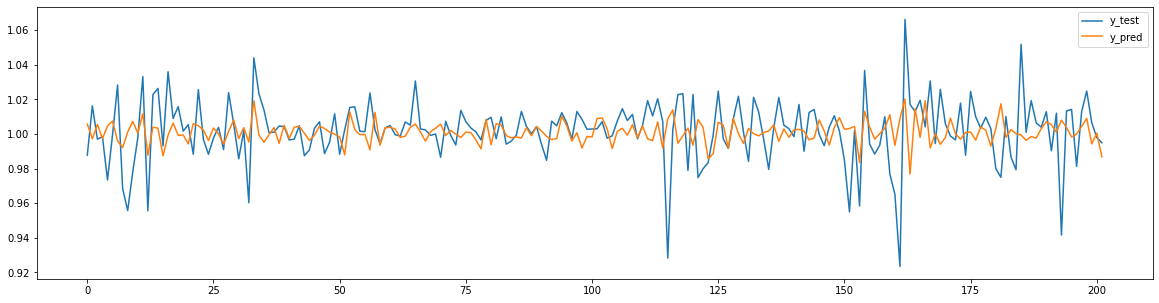

Validation Scores
mean squared error: 0.00035559
mean absolute error: 0.01327263
R2: -0.0694


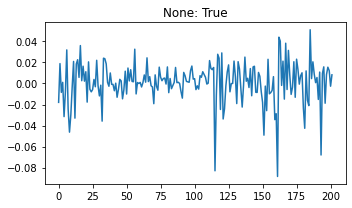

Stationarity Test Results
P-Values: 4.1013965688663484e-27
Test-stats: -14.605477918744867
Time series is stationary: True


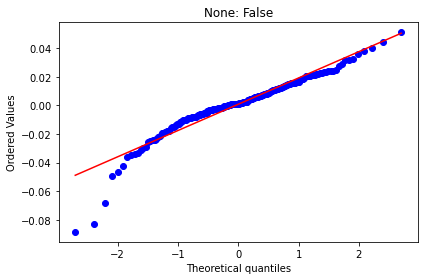

Normality Test Results
P-Values: 9.31159042914622e-14
Test-stats: 60.009862790038355
Series is normally distributed: False


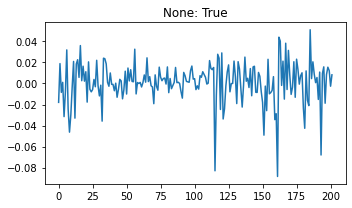

Test for Heteroskedasticity
Test p-value: 0.0315722466086467
Heteroskedasticity is present: True


In [32]:
# ar1 model als baseline
# add variables progressively, to obtain best
# random walk with drift, as benchmark model
# take root mean squared error as metrics
mval = ModelValidation(X_test,
                y_test,
                model,
                data_dict)
mval.get_model_performance()
mval.analyse_resids(print_results=True)

# Plot results

In [33]:
df_r = df_w.loc[df_ws.index].reset_index(drop=True).copy()

In [34]:
df_r["sp_tot_pred_test"] = np.concatenate([np.array(list([np.nan] * len(model.predict()))),
                                            mval.pred_inv.values]) * df_r["sp_true_vals"]

df_r["sp_tot_pred_train"] = np.concatenate([arr_inv_log_returns(model.predict()),
                                            np.array(list([np.nan] * len(mval.pred_inv.values)))]) * df_r["sp_true_vals"]

df_r["sp_tot_pred_train"] = df_r["sp_tot_pred_train"].shift(1)
df_r["sp_tot_pred_test"] = df_r["sp_tot_pred_test"].shift(1)

Validation Scores Test Data
mean squared error: 2376.7442043536525
mean absolute error: 33.51829657498586
mean absolute error %: 1.9093640143500135


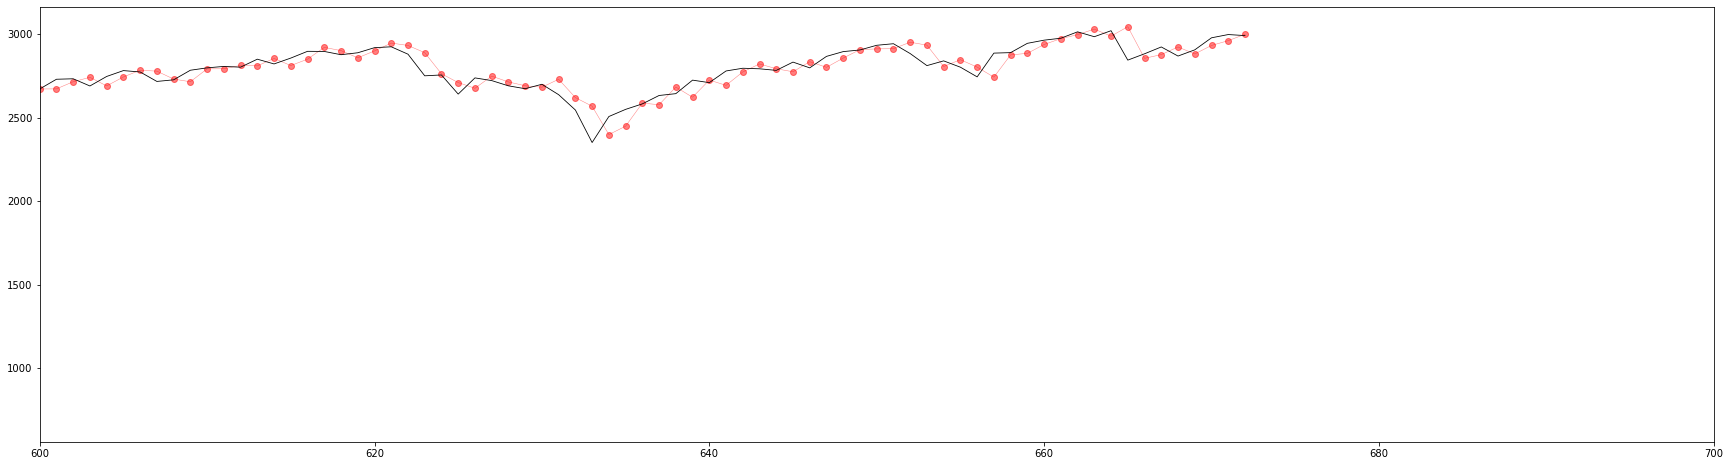

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(30, 8))
ax.plot(df_r["sp_tot_pred_train"], marker="o", lw=.5, alpha=.3, color="blue")
ax.plot(df_r["sp_tot_pred_test"], marker="o", lw=.5, alpha=.5, color="red")
ax.plot(df_r["sp_true_vals"], color="black", lw=.8)

plt.xlim([600, 700])

print("Validation Scores Test Data")
print(f"mean squared error: {np.mean((df_r.sp_tot_pred_test - df_r[data_dict['sp_true_vals']]) ** 2)}")
print(f"mean absolute error: {np.mean(abs(df_r.sp_tot_pred_test - df_r[data_dict['sp_true_vals']]))}")
print(f"mean absolute error %: {(np.mean(abs(df_r.sp_tot_pred_test - df_r[data_dict['sp_true_vals']])) / df_r[data_dict['sp_true_vals']].mean()) * 100}")

# Save model

In [28]:
save_model(df_train, model, mval, data_dict, name="four_features_vixo_splag_splagmul_pcr_ffMRF", file_path=OUT_MODEL_DIR)

Are you sure you want to save model as: f"2022-03-08_four_features_vixo_splag_splagmul_pcr_ffMRF_model.pkl"? (y/n)


 y
